In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
# Import pyMC3 and also arviz for visualisation
import pymc as pm
import arviz as az
import sympy as sp
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('bmh')
import symseaman as ss
from symseaman.substitute_dynamic_symbols import lambdify, remove_bis_eq, run, standard_substitutes
from symseaman.seaman_symbols import *
from vct.bis_system import BisSystem

[03/24/23 07:55:42] WARNING  Using NumPy C-API based implementation for BLAS functions.        ]8;id=827447;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py\blas_headers.py]8;;\:]8;id=989621;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/pytensor/tensor/blas_headers.py#1016\1016]8;;\

In [39]:
import sympy as sp
from symseaman.seaman_symbols import *
from symseaman.substitute_dynamic_symbols import run, lambdify, standard_substitutes, remove_bis, remove_bis_eq, standard_substitutes_eq, lower_and_abs
from symseaman.seaman_symbol import BisSymbol
import symseaman as ss
from symseaman.seaman_symbol import expand_bis
from symseaman.shipdict import ShipDict
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
pd.set_option('max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 4 
plt.style.use('bmh')
import vct.bokeh_plotting as bokeh_plotting
from numpy.testing import assert_almost_equal
from scipy.interpolate import interp1d
from symseaman.calculate import calculate_ship
from symseaman.to_matrix import matrix_form, matrix_form_standard, exclude, exclude_derivatives
from functools import reduce
from operator import add
from vct.regression_ols import Regression, RegressionPipeline
import dill
import seaborn as sns

In [4]:
# Read configs:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]
from vct.bis_system import BisSystem
import statsmodels.api as sm
from scipy.stats import norm

In [5]:
%reload_kedro
ship_name=ships[0]
shipdict = catalog.load(f"{ship_name}.shipdict_base")
ship_dict_from_regression = catalog.load(f"{ ship_name }.ship_dict_from_regression")

df_VCT = catalog.load(f"{ship_name}.df_VCT")
df_VCT['g'] = df_VCT['g'].fillna(method='pad')
df_VCT['rho'] = df_VCT['rho'].fillna(method='pad')

thrust_keys = catalog.load(f"params:{ship_name}.thrust_keys")

if len(thrust_keys) > 0:
    df_VCT['tprop'] = df_VCT[thrust_keys[0]]
else:
    df_VCT['tprop'] = 0
    thrust_keys=['tprop']
    
derivatives = catalog.load(f"{ship_name}.derivatives")["OLS"]
derivatives_std = catalog.load(f"{ship_name}.derivatives_std")["OLS"]

[03/24/23 07:55:54] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=16155;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=734412;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[03/24/23 07:55:56] INFO     Kedro project phd                                                      ]8;id=806391;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=874912;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=219402;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=72766;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from 'M5064-02-A.shipdict_base' (ShipDictDataSet)...  ]8;id=373410;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=866444;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.ship_dict_from_regression'           ]8;id=868065;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=13722;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

                    INFO     Loading data from 'M5064-02-A.df_VCT' (CSVDataSet)...              ]8;id=422474;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=436265;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:M5064-02-A.thrust_keys'                  ]8;id=702022;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=722759;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from 'M5064-02-A.derivatives' (IncrementalDataSet)... ]8;id=404411;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=676311;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'M5064-02-A.derivatives_std'                     ]8;id=366784;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=28905;file:///home/maa/dev/PHD/venv/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (IncrementalDataSet)...                                                               

In [6]:
lpp_ = shipdict.main_data['l']
t_ = shipdict.design_particulars['ta']
disp_ = shipdict.design_particulars['disp']
units={'fy_rudders':'force',
       'fy_rudder':'force',
       'tprop':'force',
      }
bis_system = BisSystem(lpp=lpp_, volume=disp_, units=units)

interesting = list((set(bis_system.qd.keys()) & set(df_VCT.columns)) |  (set(df_VCT.columns) & set(['test type', 'model_name','fy_rudders','fy_rudder','tprop'])))
interesting = list(set(interesting))
df_bis = bis_system.df_to_bis(df_VCT[interesting])

### Regression

In [7]:
class Regression_fy_drift(Regression):
    _eq = ss.equations.sway.eq_expanded.subs([
    (phi.bis,0),
    (r_w.bis,0),
    (delta,0),
    #(Y_uuv,0), # Note!
    ])

In [8]:
pre_set_derivatives_0 = {
    's':shipdict.rudder_coeff_data['s'],
    'kv':shipdict.rudder_coeff_data['kv'],
    'kr':shipdict.rudder_coeff_data['kr'],
    'ktyh':derivatives['ktyh'],
    'xxprop':derivatives['xxprop'],
    'xxrud':derivatives['xxrud'],
    'yuud':derivatives['yuud'],
    'ytd':derivatives['ytd'],
}
pipeline = RegressionPipeline(shipdict=shipdict, pre_set_derivatives=pre_set_derivatives_0)

mask = df_bis['test type'].isin(['Drift angle'])
df_ = df_bis.loc[mask]

pipeline['drift'] = Regression_fy_drift(df=df_)

In [9]:
regression = pipeline['drift']
regression.fit(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

In [10]:
regression.eq_excluded

Eq(-T_prop*ktyh*n_prop + Y - Y_uudelta*k_v*n_rud*u_w*v_w*(k_v**2*s*v_w**2/u_w**2 + 1), Y_uuv*u_w**2*v_w + Y_uv*u_w*v_w + Y_{v|v|}*v_w*Abs(v_w))

In [58]:
y,X=regression.label_and_features(derivatives=pre_set_derivatives_0, meta_data=pipeline.meta_data)

In [59]:
X

,yuv,yvav,yuuv
15,-0.002671,-0.000234,-0.000467
16,-0.005261,-0.000928,-0.000909
17,-0.007691,-0.002061,-0.001303
18,-0.009887,-0.003599,-0.001630
19,-0.011783,-0.005494,-0.001873
20,-0.013321,-0.007691,-0.002023
21,-0.005050,-0.000442,-0.001213
22,-0.009946,-0.001754,-0.002362
23,-0.014540,-0.003896,-0.003387


In [13]:
data = df_
basic_model = pm.Model()

columns = list(X.columns)

sigmas_ = [derivatives_std[key] for key in columns]
mus_ = [derivatives[key] for key in columns]
sigma_ = 0.0001*data['fy'].abs().max()

with basic_model:
    # Priors for unknown model parameters
    parameters = pm.Normal("parameters", mu=mus_, 
                           sigma=sigmas_, 
                           shape=len(columns))
    
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = pm.math.dot(X, parameters)

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("fy_obs", mu=mu, sigma=sigma, observed=y)
    #ν = pm.Uniform("ν", 1, 10)
    #Y_obs = pm.StudentT("fy_obs", nu=ν, mu=mu, sigma=sigma, observed=y)

In [14]:
with basic_model:
    # draw 1000 posterior samples
    trace = pm.sample(draws=10000)

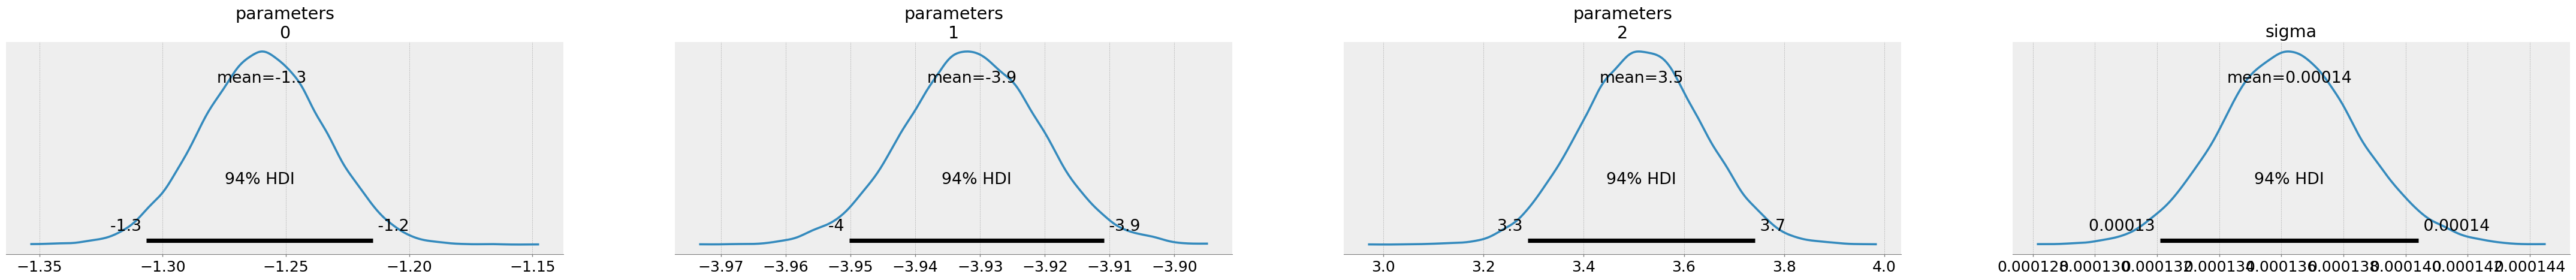

In [15]:
with basic_model:
    az.plot_posterior(trace,
                  var_names=['parameters','sigma'],
                  textsize=18,
                  point_estimate='mean',
                  rope_color='black')

In [16]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
parameters[0],-1.260,0.025,-1.307,-1.215,0.000,0.000,7549.0,9564.0,1.0
parameters[1],-3.931,0.010,-3.950,-3.911,0.000,0.000,11709.0,12194.0,1.0
parameters[2],3.516,0.122,3.288,3.742,0.001,0.001,7837.0,10112.0,1.0
sigma,0.000,0.000,0.000,0.000,0.000,0.000,13915.0,12230.0,1.0


In [17]:
means = (trace.posterior['parameters'].data[0].mean(axis=0) + trace.posterior['parameters'].data[1].mean(axis=0))/2
means = {key:mean for key,mean in zip(columns,means)}

In [18]:
means

{'yuv': -1.2597642777779732,
 'yvav': -3.931258553593159,
 'yuuv': 3.516065519235042}

In [19]:
stds = (trace.posterior['parameters'].data[0].std(axis=0) + trace.posterior['parameters'].data[1].std(axis=0))/2
stds = {key:std for key,std in zip(columns,stds)}

In [20]:
stds

{'yuv': 0.024640465195709595,
 'yvav': 0.010426129435755604,
 'yuuv': 0.12152742387116625}

In [21]:
df_parameters = pd.concat([
pd.Series(means, name='Bayesian'),
pd.Series({key:derivatives[key] for key in means.keys()}, name='splitted OLS'),
pd.Series({key:regression.regression.params[key] for key in means.keys()}, name='OLS'),
    
], axis=1).transpose()

In [22]:
df_parameters

,yuv,yvav,yuuv
Bayesian,-1.259764,-3.931259,3.516066
splitted OLS,-1.346556,-3.888942,3.664677
OLS,-0.258130,-4.961268,0.169063


In [23]:
df_uncertainties = pd.concat([
pd.Series(stds, name='Bayesian'),
pd.Series({key:derivatives_std[key] for key in stds.keys()}, name='splitted OLS'),
pd.Series({key:regression.regression.bse[key] for key in stds.keys()}, name='OLS'),
    
], axis=1).transpose()

In [24]:
df_uncertainties

,yuv,yvav,yuuv
Bayesian,0.024640,0.010426,0.121527
splitted OLS,0.177935,0.010662,0.362330
OLS,0.544708,0.507031,2.042901


In [25]:
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                                        OLS Regression Results                                                        
======================================================================================================================================
Dep. Variable:     -fy + ktyh*nprop*tprop + kv*nrud*u*v*yuud*(kv**2*s*v**2/u**2 + 1)   R-squared (uncentered):                   0.997
Model:                                                                           OLS   Adj. R-squared (uncentered):              0.996
Method:                                                                Least Squares   F-statistic:                              726.8
Date:                                                               Fri, 24 Mar 2023   Prob (F-statistic):                    4.52e-08
Time:                                                                       07:56:42   Log-Likelihood:                          48.698
No. Observations:                                                                  9   AIC:                                     -91.40
Df Residuals:                                                                      6   BIC:                                     -90.80
Df Model:                                                                          3                                                  
Covariance Type:                                                           nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
yuv           -0.2581      0.545     -0.474      0.652      -1.591       1.075
yvav          -4.9613      0.507     -9.785      0.000      -6.202      -3.721
yuuv           0.1691      2.043      0.083      0.937      -4.830       5.168
==============================================================================
Omnibus:                        1.674   Durbin-Watson:                   2.816
Prob(Omnibus):                  0.433   Jarque-Bera (JB):                0.400
Skew:                           0.517   Prob(JB):                        0.819
Kurtosis:                       3.003   Cond. No.                         50.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

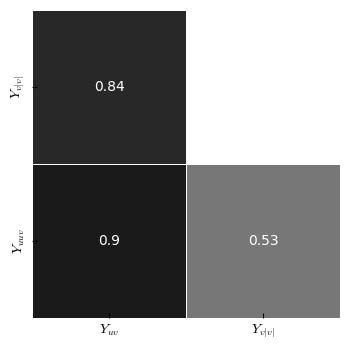

In [156]:
import matplotlib as mpl

corr = X.corr()

columns_sympy = {
    'yuv':Y_uv,
    'yuuv':Y_uuv,
    'yvav':Y_vav,
}
columns_latex = {key:f"${sp.latex(value)}$" for key,value in columns_sympy.items()}
corr.rename(columns=columns_latex, index=columns_latex, inplace=True)

fig,ax=plt.subplots()
ax.set_aspect('equal', 'box')
matrix=np.triu(np.ones((len(corr),len(corr))))

import matplotlib as mpl
cmap = mpl.cm.get_cmap('gray_r')
cmap.set_bad("white")

sns.heatmap(corr.iloc[1:,0:-1], mask=matrix[1:,0:-1], linewidths=.5, annot=True, cmap=cmap, cbar=False, ax=ax, square=True, vmin=0, vmax=1)
ax.grid(False)

